# Advance Prompt Customization for Anthropic

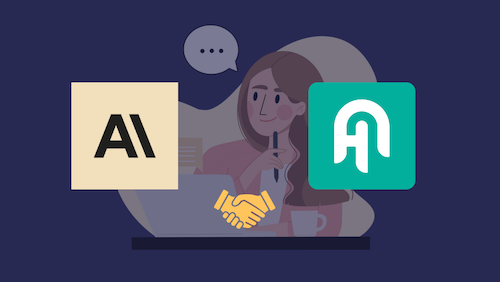

*Notebook by Bilge Yucel ([LI](https://www.linkedin.com/in/bilge-yucel/) & [X (Twitter)](https://twitter.com/bilgeycl))*

In this example, we'll create a RAG application using prompting techniques in [Anthropic's Prompt Engineering Guide](https://docs.anthropic.com/claude/docs/prompt-engineering). This application will use Anthropic Claude 3 models and [Haystack](https://github.com/deepset-ai/haystack) to extract relevant quotes from given documents and generate an answer based on extracted quotes.

**📚 Useful Sources:**
* [Docs: AnthropicChatGenerator](https://docs.haystack.deepset.ai/docs/anthropicchatgenerator)
* [Integration: Anthropic](https://haystack.deepset.ai/integrations/anthropic)

## Setup the Development Environment

Install [antropic-haystack](https://pypi.org/project/anthropic-haystack/) package and other required packages with pip:

In [ ]:
!pip install anthropic-haystack "datasets>=2.6.1" "sentence-transformers>=3.0.0"

You need an `ANTHROPIC_API_KEY` to work with Claude models. Get your API key [here](https://docs.anthropic.com/claude/docs/getting-access-to-claude#step-3-generate-an-api-key)

In [3]:
import os
from getpass import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass("Enter the ANTHROPIC_API_KEY: ")

Enter the ANTHROPIC_API_KEY: ··········


## Download the Dataset

We'll use the [bilgeyucel/seven-wonders](https://huggingface.co/datasets/bilgeyucel/seven-wonders) dataset on Hugging Face

In [4]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

## Create Embeddings and Index into the DocumentStore

In [5]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

document_store = InMemoryDocumentStore()

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

151

## Build the Prompt

Claude models are familiar with prompts that contain XML tags, as they were exposed to such prompts during training. By wrapping key parts of the prompt (such as instructions, examples, or input data) in XML tags, we can help Claude better understand the context and generate more accurate outputs.

To formulate a prompt that first extracts quotes from relevant documents and then refers to these quotes to generate the answer, follow these steps in your prompt:

1. Place retrieved documents between `<documents> </documents>` tags.
2. Render each document between `<document> </document>` tags, including a document index for Claude to reference later.
3. Instruct Claude to extract quotes within `<quotes> </quotes>` tags, including document index information.
4. Ensure that Claude generates the answer between `<answer> </answer>` tags.


In [6]:
prompt = """
Here is a document, in <document></document> XML tags:

<documents>
{% for document in documents %}
 <document index="{{loop.index}}">
  {{document.content}}
  </document>
{% endfor %}
</documents>

First, extract, word-for-word, any quotes relevant to the question, enclose the full list of quotes in <quotes></quotes> XML tags with the corresponding document index and use these quotes to an answer to the question.

If there are no quotes in this document that seem relevant to this question, please say "I can't find any relevant quotes".

Then, answer the question in <answer></answer> tags. Do not include or reference quoted content verbatim in the answer. Ensure that your answer is accurate and doesn't contain any information not directly supported by the quotes. Make references to quotes relevant to each section of the answer solely by adding their bracketed numbers at the end of relevant sentences

Here is the question: {{question}}
"""

The rendered prompt should look like this when it's fed with relevant documents and the question:

```xml
Here is a document, in <document></document> XML tags:

<documents>
<document index="1">
  (the text content of the first document)
</document>
<document index="2">
  (the text content of the second document)
</document>
<document index="3">
  (the text content of the third document)
</document>
...
</documents>

First, extract, word-for-word, any quotes relevant to the question, enclose the full list of quotes in <quotes></quotes> XML tags with the corresponding document index and use these quotes to an answer to the question.

If there are no quotes in this document that seem relevant to this question, please say "I can't find any relevant quotes".

Then, answer the question in <answer></answer> tags. Do not include or reference quoted content verbatim in the answer. Ensure that your answer is accurate and doesn't contain any information not directly supported by the quotes. Make references to quotes relevant to each section of the answer solely by adding their bracketed numbers at the end of relevant sentences

Here is the question: (user question)
```

And in return, Claude's response should look like this:


```xml
<quotes>
<quote index="1">Large numbers of people came to Ephesus in March and in the beginning of May to attend the main Artemis Procession.</quote>
<quote index="2">The Temple of Artemis or Artemision (Greek: Ἀρτεμίσιον; Turkish: Artemis Tapınağı), also known as the Temple of Diana, was a Greek temple dedicated to an ancient, local form of the goddess Artemis (identified with Diana, a Roman goddess).</quote>
</quotes>

<answer>
According to the documents, people visited the Temple of Artemis in Ephesus primarily for religious reasons to attend festivals and processions dedicated to the goddess Artemis (also known as Diana). The temple was dedicated to an ancient local form of the goddess and held a main Artemis Procession in March and early May that drew large crowds. [1] The temple was considered an important religious site for the worship of Artemis in the Greek world. [2] People likely traveled there to make offerings, participate in rituals, and celebrate the goddess during major festivals and ceremonies held at the sacred site.
</answer>
```

## Initialize RAG Pipeline Components

Initialize components required for a RAG pipeline:
- [SentenceTransformersTextEmbedder](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder): to create embeddings using for the query using sentence-transformers models
- [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/docs/inmemoryembeddingretriever): to retrieve relevant documents
- [DynamicChatPromptBuilder](https://docs.haystack.deepset.ai/docs/dynamicchatpromptbuilder): to construct prompts dynamically by processing `ChatMessage` objects
- [AnthropicChatGenerator](https://docs.haystack.deepset.ai/docs/anthropicchatgenerator): to use chat completion API of Anthropic Claude models, we'll use `claude-3-sonnet-20240229` for this example

In [7]:
from haystack.components.builders import DynamicChatPromptBuilder
from haystack_integrations.components.generators.anthropic import AnthropicChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store)

messages = [
    ChatMessage.from_system("You are an expert who answers questions based on the given documents."),
    ChatMessage.from_user(prompt),
]

prompt_builder = DynamicChatPromptBuilder(runtime_variables=["documents"])
llm = AnthropicChatGenerator(model="claude-3-sonnet-20240229")

## Build the RAG Pipeline

Learn how to build a pipeline in [Creating Pipelines](https://docs.haystack.deepset.ai/docs/creating-pipelines).

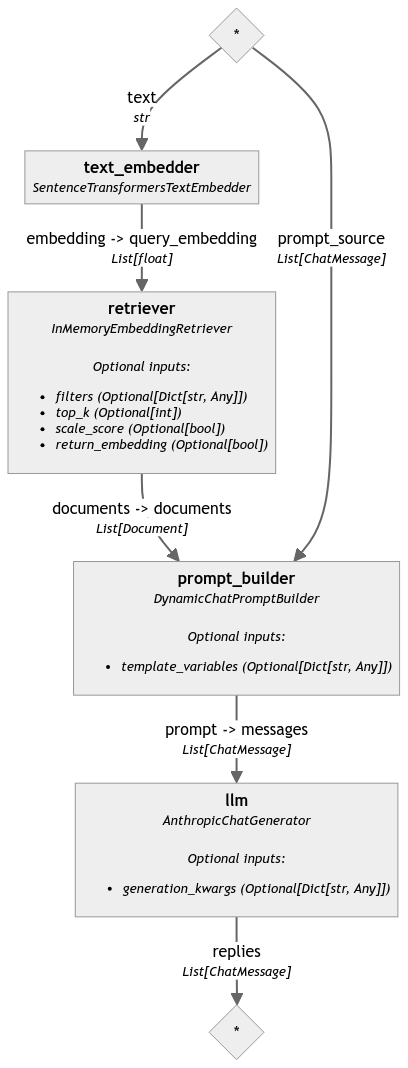

In [8]:
from haystack import Pipeline

rag_with_quotes = Pipeline()
# Add components to your pipeline
rag_with_quotes.add_component("text_embedder", text_embedder)
rag_with_quotes.add_component("retriever", retriever)
rag_with_quotes.add_component("prompt_builder", prompt_builder)
rag_with_quotes.add_component("llm", llm)

# Now, connect the components to each other
rag_with_quotes.connect("text_embedder.embedding", "retriever.query_embedding")
rag_with_quotes.connect("retriever", "prompt_builder.documents")
rag_with_quotes.connect("prompt_builder", "llm")

## Test Different Questions

In [9]:
question = "Why were people visiting the Temple of Artemis?" # @param ["Why were people visiting the Temple of Artemis?", "How did Colossus of Rhodes collapse?", "What is the importance of Colossus of Rhodes?", "Why did people build Great Pyramid of Giza?", "What does Rhodes Statue look like?"]

result = rag_with_quotes.run(
    data={
        "text_embedder" : {"text": question},
        "retriever" : {"top_k": 5},
        "prompt_builder": {"template_variables": {"question": question}, "prompt_source": messages},
    }
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(result["llm"]["replies"][0].text)

<quotes>
<quote index="1">Large numbers of people came to Ephesus in March and in the beginning of May to attend the main Artemis Procession.</quote>
<quote index="3">The fame of the Temple of Artemis was known in the Renaissance, as demonstrated in this imagined portrayal of the temple in a 16th-century hand-colored engraving by Martin Heemskerck.</quote>
</quotes>

<answer>
People visited the Temple of Artemis in Ephesus primarily to attend the main Artemis Procession, which took place in March and early May every year. [1] The temple was famous and its magnificence was well-known, attracting visitors even in the Renaissance period centuries later. [3] The quotes indicate that the major draw for visitors to Ephesus was the religious celebrations and festivals honoring the goddess Artemis, which were a key part of the temple's significance and renown.
</answer>


### Extract the Quotes

In [11]:
import re

re.findall(r'<quote .*?>([\s\S]*?)<\/quote>', result["llm"]["replies"][0].text)

['Large numbers of people came to Ephesus in March and in the beginning of May to attend the main Artemis Procession.',
 'The fame of the Temple of Artemis was known in the Renaissance, as demonstrated in this imagined portrayal of the temple in a 16th-century hand-colored engraving by Martin Heemskerck.']

### Extract the Answer

In [12]:
import re

re.findall(r'<answer>([\s\S]*?)<\/answer>', result["llm"]["replies"][0].text)

["\nPeople visited the Temple of Artemis in Ephesus primarily to attend the main Artemis Procession, which took place in March and early May every year. [1] The temple was famous and its magnificence was well-known, attracting visitors even in the Renaissance period centuries later. [3] The quotes indicate that the major draw for visitors to Ephesus was the religious celebrations and festivals honoring the goddess Artemis, which were a key part of the temple's significance and renown.\n"]